In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical, SeveralSourceDataset
from data import data_dirs as data_env, get_label_with_context

from model import (
    UnetR34, get_resnet34,
    accuracy_segmentation, tensorboard_cb, jaccard_index_one_class, jaccard_index_zero_class
)

from result_visualization import show_results

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,   # matplotlib.pyplot
    nn,    # torch.nn
    optim  # torch.optim
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

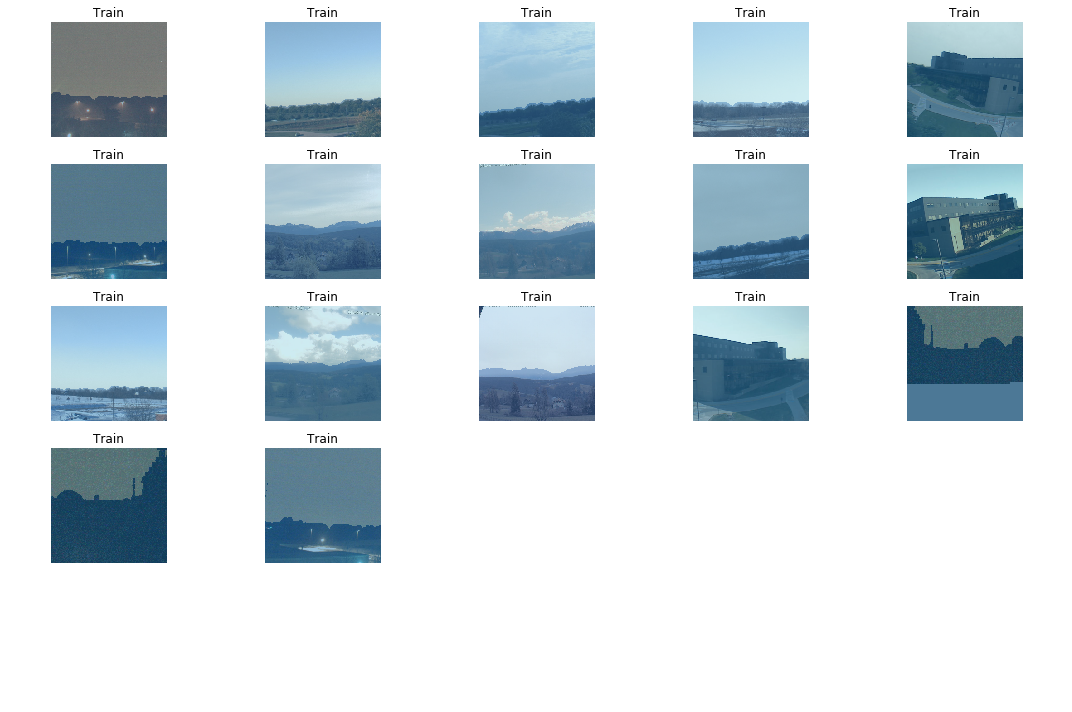

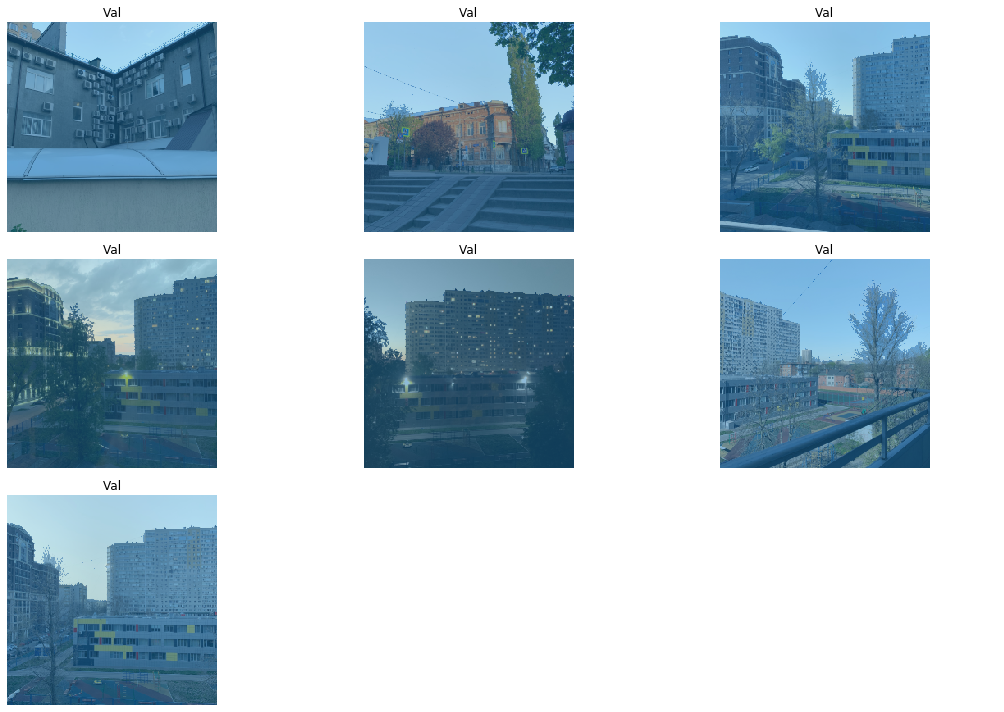

In [2]:
sizes = 256

src = (
    SegItemListCustom
    .from_folder(data_env.get_subdir("root"))
    .split_by_folder("train_skyFinder", "test_iphoneXR_v")
    .label_from_func(get_label_with_context,
                     classes=["Sky", "Other"])
)
train_data = (
    src
    .transform(tfms=get_transforms()
                  , size=sizes, tfm_y=True)
    .databunch(bs=17)
    .normalize(imagenet_stats)
)
classes = train_data.c
train_data.valid_dl.batch_size = 7

train_data.show_batch(figsize=(15,10), title="Train")
train_data.show_batch(figsize=(15,10), title="Val", ds_type=DatasetType.Valid)

In [3]:
model = UnetR34(get_resnet34(), classes_num=classes)

learner = Learner(train_data, model)
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCEWithLogitsLoss()
learner.metrics = [accuracy_segmentation, jaccard_index_one_class, jaccard_index_zero_class]

# learner.freeze_to(1)

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 2.09E-02


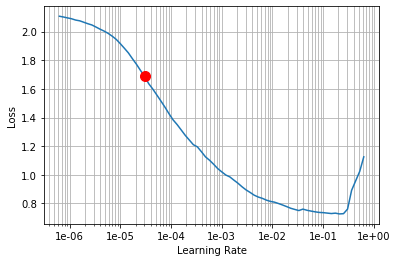

In [4]:
learner.lr_find()
learner.recorder.plot(suggestion=True, show_grid=True)

In [5]:
tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="unet34_osp_full_s256_mlr1e3_bs17_e25")

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time
0,0.043081,0.087723,0.968717,87.168850,96.027493,05:55
1,0.046612,0.142343,0.944465,79.992618,92.861406,05:54
2,0.058266,0.340830,0.904973,70.166026,87.762195,05:52
3,0.047243,0.084784,0.974860,89.144186,96.832002,05:55
4,0.037517,0.268056,0.943309,79.419306,92.743441,05:52
5,0.033620,0.075174,0.970289,87.976677,96.203544,05:52
6,0.032771,0.073148,0.971130,88.432177,96.295447,05:52
7,0.025360,0.153449,0.947673,80.423738,93.334426,05:52
8,0.023556,0.503423,0.886520,65.943347,85.456389,05:52
9,0.022835,0.111938,0.963867,85.387613,95.419603,05:53


profiler execution failed


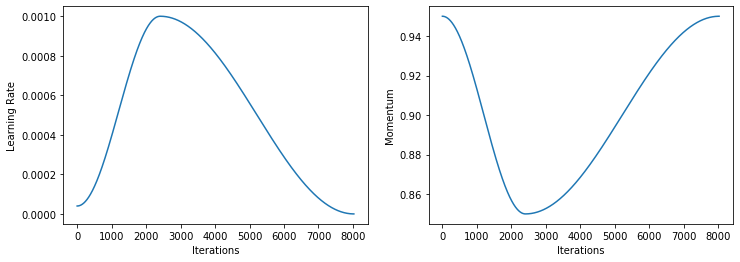

In [6]:
learner.fit_one_cycle(18, max_lr=1e-03, callbacks=[tb_callback(learner)])
# learner.fit(epochs=25, lr=1e-03, callbacks=[tb_callback(learner)])
learner.recorder.plot_lr(show_moms=True)

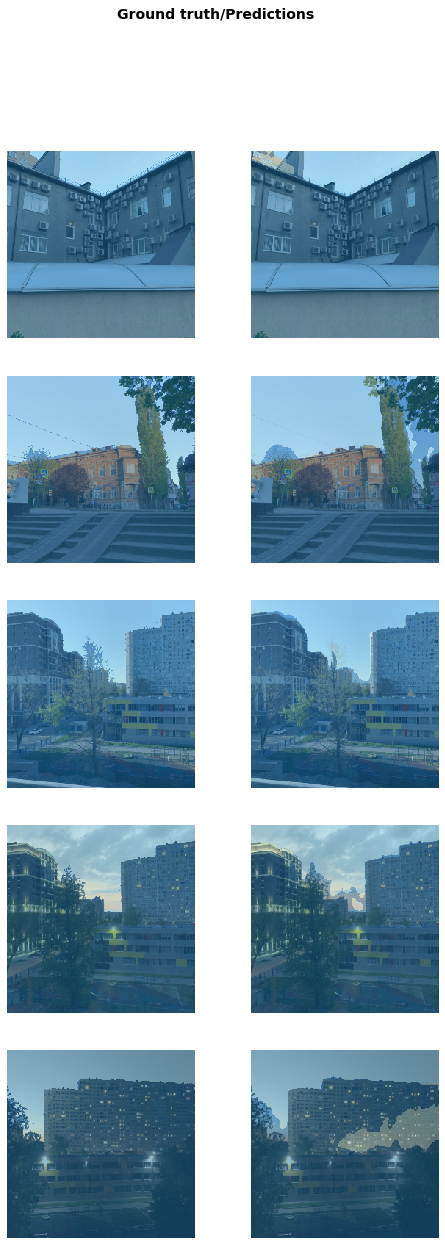

In [7]:
learner.show_results()

In [8]:
learner.save("/home/dmitri/Documents/model_weights/unet34/unet34_osp_full_e18_mlr1e3_bs17_2d")
learner.export("/home/dmitri/Documents/model_weights/unet34/unet34_osp_full_e18_mlr1e3_bs17_2d")

In [9]:
model.close()